# Feature Engineering for Transformer Model

This notebook processes the downloaded and decompressed Wikipedia articles and should therefore be run __after__ ``download_wikipedia.ipynb`` and ``download_foursquare.ipynb``. Transformer features will be created.

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import gc
import json
import re
import math
from collections import Counter
import warnings
warnings.filterwarnings(action="ignore")

from tqdm.notebook import tqdm
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from transformers import AutoTokenizer
from transformers import AutoModel
import torch
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy import distance
import seaborn as sns
sns.set_style("ticks",{'axes.grid' : True})

import multiprocessor_wiki

Define constants.

- ``PATH``: Path to the base data folder
- ``REGION_NAME``: Name of the region to consider
- ``CPU_CORES``: How many cores to use to process data, default=all - 1
- ``MODEL_NAME``: Which HuggingFace model to use for creating the embeddings
- ``ONLY_SUMMARY``: Whether to use only the summary or the full article
- ``WEIGHTING``: Whether to employ weighting strategy for subdocuments
- ``MEAN``: Whether to calculate the mean of subdocuments
- ``DEVICE``: Which device to use for Transformer model (CPU/GPU/TPU)
- ``MAX_LENGTH``: Maximum sequence input length for Transformer
- ``WEIGHT_FUNC``: Which weighting function to use ("tanh", "linear" or "cubic")
- ``LAST_K_HIDDEN``: From how many last hidden layers to extract embeddings
- ``MAX_DIST``: Maximum radius around each venue for Wikipedia articles to be considered
- ``K_CLOSEST``:  Cutoff/upper bound for number of articles in range

In [3]:
PATH = "C:/Users/Tim/.keras/datasets/wikipedia_rss/"
REGION_NAME = "NY"
CPU_CORES = os.cpu_count() - 1
MODEL_NAME = "distilbert-base-uncased"
ONLY_SUMMARY = True
WEIGHTING = True
MEAN = True
DEVICE = "cpu"
MAX_LENGTH = 512
WEIGHT_FUNC = "tanh"
LAST_K_HIDDEN = 4
MAX_DIST = 2000
K_CLOSEST = math.inf

Load data.

In [4]:
with open(PATH+f"wikipedia/wikipedia_selected_{REGION_NAME}.ndjson") as fin:
    data_loaded = json.load(fin)

In [5]:
df = pd.DataFrame(data_loaded).rename(columns={0: "name", 1: "coords", 2: "templates", 3: "text",
                                               4: "wikilinks", 5: "ext_links", 6: "text_length"})
print(df.shape)
df.head(5)

(13243, 7)


,name,coords,templates,text,wikilinks,ext_links,text_length
0,"Rose Hill, Manhattan","[40.742, -73.983]",None,thumb|right|300px|The 69th Regiment Armory on ...,"[File:69th-regiment-armory.JPG, 69th Regiment ...",[https://query.nytimes.com/gst/fullpage.html?r...,10789
1,American Surety Building,"[40.7081, -74.0112]","{'name': 'American Surety Building', 'image': ...",The American Surety Building (also known as th...,"[Manhattan, Neoclassical architecture, Bruce P...","[http://maps.nyc.gov/, https://www.nytimes.com...",26150
2,Lenox Hill,"[40.769, -73.962]",None,thumb|200px|1st Avenue in Lenox Hill \n \n Len...,"[File:1st Avenue - Manhattan.jpg, Manhattan, U...",[https://www.nytimes.com/1995/12/31/realestate...,7467
3,Miller Field (Staten Island),"[40.564166666666665, -74.09555555555555]",{'name': 'Miller Army Air Field Historic Distr...,Miller Field was a United States Army facility...,"[New Dorp, Staten Island, Staten Island, New Y...","[https://cris.parks.ny.gov/, http://webarchive...",4516
4,Myrtle Avenue station (BMT Fourth Avenue Line),"[40.6937, -73.9833]","{'type': 'former', 'name': 'Myrtle Avenue', 'b...",Myrtle Avenue was a local station on the Manha...,"[BMT Fourth Avenue Line, side platform, Brookl...","[https://www.newspapers.com/clip/48814840/, ht...",4636


Load venue data.

In [6]:
df_structured = pd.read_csv(PATH + "structured_preprocessed.csv")
df_structured.rename(columns={"lat":"latitude", "long":"longitude"}, inplace=True)
print(df_structured.shape)
df_structured.head()

(2836, 7)


,venue_id,latitude,longitude,borough,category,org_category,total_visits
0,3fd66200f964a52001e51ee3,40.726961,-73.980039,Manhattan,Bar,Dive Bar,1
1,3fd66200f964a52003e51ee3,40.724822,-73.981456,Manhattan,Bar,Dive Bar,15
2,3fd66200f964a52010e51ee3,40.727027,-73.982702,Manhattan,Bar,Dive Bar,14
3,3fd66200f964a52011e81ee3,40.762812,-73.967519,Manhattan,Bar,Dive Bar,18
4,3fd66200f964a52018e51ee3,40.725112,-73.981278,Manhattan,Bar,Dive Bar,29


Remove additional tags and Wikipedia formatting.

In [7]:
def clean_str(text, only_summary):
    subbed_1 = subbed = re.sub('<.*>',  '', text)
    subbed_2 = re.sub('thumb|',  '', subbed_1)
    if only_summary:
        subbed_2 = subbed_2.split("==")[0]  
    return subbed_2 if len(subbed_2) > 10 else pd.NA

df["text"] = df["text"].apply(clean_str, args=[ONLY_SUMMARY])
df = df.dropna(axis=0, subset=["text"])  # drop NA rows
print(df.shape)

(13226, 7)


Save one dimensional file.

In [8]:
df_dropped = df.drop(["templates", "wikilinks", "ext_links"], axis=1, inplace=False)
df_dropped["lat"] = [x[0] for x in df["coords"]]
df_dropped["long"] = [x[1] for x in df["coords"]]
df_dropped = df_dropped.drop(["coords"], axis=1, inplace=False)
if ONLY_SUMMARY:
    df_dropped.to_csv(PATH+f"wikipedia/wikipedia_selected_{REGION_NAME}.csv", index=False)
else:
    df_dropped.to_csv(PATH+f"wikipedia/wikipedia_selected_{REGION_NAME}_FULL.csv", index=False)
df_dropped.head()

,name,text,text_length,lat,long
0,"Rose Hill, Manhattan",|right|300px|The 69th Regiment Armory on Lexin...,10789,40.742000,-73.983000
1,American Surety Building,The American Surety Building (also known as th...,26150,40.708100,-74.011200
2,Lenox Hill,|200px|1st Avenue in Lenox Hill \n \n Lenox Hi...,7467,40.769000,-73.962000
3,Miller Field (Staten Island),Miller Field was a United States Army facility...,4516,40.564167,-74.095556
4,Myrtle Avenue station (BMT Fourth Avenue Line),Myrtle Avenue was a local station on the Manha...,4636,40.693700,-73.983300


Load tokenizer and pretrained model.

In [9]:
model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Max length: {tokenizer.model_max_length}")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Max length: 512


In [10]:
if ONLY_SUMMARY:
    hf_data = load_dataset('csv', data_files=PATH+f"wikipedia/wikipedia_selected_{REGION_NAME}.csv")
else:
    hf_data = load_dataset('csv', data_files=PATH+f"wikipedia/wikipedia_selected_{REGION_NAME}_FULL.csv")
hf_data

Using custom data configuration default-48f798b5196f486d


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to C:\Users\Tim\.cache\huggingface\datasets\csv\default-48f798b5196f486d\0.0.0\6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['name', 'text', 'text_length', 'lat', 'long'],
        num_rows: 13226
    })
})

In [11]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        add_special_tokens=True,
        padding=True, truncation=True,
        max_length=MAX_LENGTH,
        # return_tensors="pt"
    )

hf_data_encoded = hf_data.map(tokenize, batched=True, batch_size=df.shape[0])

  0%|          | 0/1 [00:00<?, ?ba/s]

In [12]:
len(hf_data_encoded["train"]["input_ids"][1])

512

Define function for extracting the \[cls\] token for the last four hidden layers.

In [13]:
def extract_features_cls(batch):
    # store inputs in separate variables
    input_ids = torch.tensor(batch["input_ids"]).to(DEVICE)
    attention_mask = torch.tensor(batch["attention_mask"]).to(DEVICE)

    # feed inputs into model and save outputs
    with torch.no_grad():
        output = model(input_ids, attention_mask, output_hidden_states=True)
        hidden_states = output.hidden_states[-LAST_K_HIDDEN:]
        concatted_states = torch.concat(hidden_states, axis=2).cpu().numpy()

    # extract the hidden states for the CLS token only
    cls_lhs = concatted_states[:, 0, :]

    # return results
    batch["cls_hidden_state"] = cls_lhs
    return batch

Find out mean token length of article.

In [14]:
att_mask = hf_data_encoded["train"]["attention_mask"]
mask_lens = [sum(mask) for mask in att_mask]
print(f"The average article has {np.mean(mask_lens)} tokens")

The average article has 133.58241342809617 tokens


Create word embeddings for each article.

In [15]:
# hf_encoded = hf_data_encoded.map(extract_features_cls, 
#                                  batched=True,
#                                  batch_size=128)
# embeddings = np.array(hf_encoded["train"]["cls_hidden_state"])
# embeddings.shape

In [16]:
# embeddings = np.array(hf_encoded["train"]["cls_hidden_state"])
# embedding_df = pd.DataFrame(data=embeddings)
# emb_col_names = [f"embedding_{i}" for i in range(embeddings.shape[1])]
# embedding_df.columns = emb_col_names
# if ONLY_SUMMARY:
#     embedding_df.to_csv(PATH+f"venues_bert_vectors_LAST_{LAST_K_HIDDEN}.csv", index=False)
# else:
#     embedding_df.to_csv(PATH+f"venues_bert_vectors_LAST_{LAST_K_HIDDEN}_FULL.csv", index=False)
# print(embedding_df.shape)
# embedding_df.head()

Alternatively load processed embeddings.

In [17]:
if ONLY_SUMMARY:
    embedding_df = pd.read_csv(PATH+f"venues_bert_vectors_LAST_{LAST_K_HIDDEN}.csv")
else:
    embedding_df = pd.read_csv(PATH+f"venues_bert_vectors_LAST_{LAST_K_HIDDEN}_FULL.csv")
emb_col_names = embedding_df.columns
print(embedding_df.shape)
embedding_df.head()

(13226, 3072)


,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_3062,embedding_3063,embedding_3064,embedding_3065,embedding_3066,embedding_3067,embedding_3068,embedding_3069,embedding_3070,embedding_3071
0,-0.526676,-0.702344,-0.392028,0.046045,0.189469,-0.106948,-0.420722,-0.168178,-0.623543,-0.676071,...,0.045866,-0.017992,0.084301,-0.562944,0.258235,-0.074027,-0.161628,0.273979,0.352641,0.775011
1,-0.457073,-0.618344,-0.561515,0.205052,0.218935,0.062639,-0.624263,-0.543638,-0.732029,-0.317487,...,0.188706,-0.347753,0.150500,-0.483816,0.224380,-0.209450,-0.180172,0.421988,0.171194,0.552664
2,-0.468631,-0.737294,-0.570606,0.084071,0.291877,-0.070572,-0.494196,-0.228723,-0.610233,-0.503486,...,0.048750,-0.133502,0.041183,-0.592192,0.297426,-0.123245,-0.241094,0.242403,0.320455,0.607622
3,-0.361590,-0.536362,-0.508738,-0.024905,0.336211,0.014100,-0.418654,-0.210742,-0.682765,-0.230468,...,0.034016,-0.362666,0.337491,-0.656979,0.131086,0.232773,-0.149192,0.536848,0.123052,0.608280
4,-0.412264,-0.873946,-0.540666,-0.041418,0.374387,0.024146,-0.389521,-0.230020,-0.722442,-0.187966,...,-0.097683,-0.457972,0.226274,-0.529338,0.394718,0.011816,-0.242552,0.447886,0.403720,0.524198


Create feature vectors for each venue by spatially weighting article embeddings.

In [18]:
df.reset_index(drop=True, inplace=True)  # make sure index is from 0 to n-1
structured_features = multiprocessor_wiki.process_text_features(df_structured, df, embedding_df.to_numpy(),
                                                                emb_col_names, MAX_DIST, CPU_CORES,
                                                                WEIGHTING, MEAN, WEIGHT_FUNC, K_CLOSEST)

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
print(structured_features.shape)
structured_features.head(10)

(2836, 3080)


,venue_id,latitude,longitude,borough,category,org_category,total_visits,embedding_0,embedding_1,embedding_2,...,embedding_3063,embedding_3064,embedding_3065,embedding_3066,embedding_3067,embedding_3068,embedding_3069,embedding_3070,embedding_3071,article_count
0,3fd66200f964a52001e51ee3,40.726961,-73.980039,Manhattan,Bar,Dive Bar,1,-0.062071,-0.097178,-0.069577,...,-0.052685,0.010986,-0.069755,0.026353,-0.019935,-0.030799,0.043548,0.050848,0.068039,856
1,3fd66200f964a52003e51ee3,40.724822,-73.981456,Manhattan,Bar,Dive Bar,15,-0.069718,-0.11177,-0.078443,...,-0.059709,0.01233,-0.079474,0.030337,-0.022145,-0.034773,0.048387,0.057833,0.07536,852
2,3fd66200f964a52010e51ee3,40.727027,-73.982702,Manhattan,Bar,Dive Bar,14,-0.074433,-0.116254,-0.082995,...,-0.062746,0.013605,-0.081564,0.030894,-0.023386,-0.035927,0.050782,0.06123,0.081813,982
3,3fd66200f964a52011e81ee3,40.762812,-73.967519,Manhattan,Bar,Dive Bar,18,-0.094893,-0.144206,-0.103662,...,-0.067645,0.023879,-0.107948,0.039623,-0.027029,-0.032887,0.063146,0.078024,0.105435,1221
4,3fd66200f964a52018e51ee3,40.725112,-73.981278,Manhattan,Bar,Dive Bar,29,-0.068102,-0.108868,-0.076608,...,-0.058303,0.012036,-0.077477,0.029539,-0.021663,-0.033969,0.047322,0.056421,0.073728,863
5,3fd66200f964a5201be41ee3,40.719238,-73.985588,Manhattan,Bar,Dive Bar,17,-0.074527,-0.122512,-0.083022,...,-0.06169,0.01346,-0.086967,0.034429,-0.02353,-0.035387,0.050915,0.061384,0.080623,874
6,3fd66200f964a52025e41ee3,40.72488,-73.994685,Manhattan,Bar,Dive Bar,26,-0.111875,-0.174933,-0.120087,...,-0.088188,0.021318,-0.116937,0.044632,-0.030874,-0.047606,0.068924,0.088975,0.125505,1193
7,3fd66200f964a52029e31ee3,40.725638,-73.984561,Manhattan,Bar,Dive Bar,15,-0.082956,-0.1312,-0.092229,...,-0.069818,0.015339,-0.090974,0.034611,-0.025585,-0.039598,0.055665,0.068519,0.090649,1019
8,3fd66200f964a5202ee41ee3,40.728543,-73.984699,Manhattan,Bar,Dive Bar,34,-0.086315,-0.132255,-0.095396,...,-0.07121,0.016312,-0.09156,0.0345,-0.026654,-0.040059,0.057359,0.07048,0.096252,1061
9,3fd66200f964a52033e61ee3,40.72478,-73.994703,Manhattan,Bar,Dive Bar,10,-0.111822,-0.174947,-0.120036,...,-0.088104,0.02128,-0.116991,0.044704,-0.030856,-0.047577,0.068944,0.088897,0.125438,1190


See how many venues have no Wikipedia articles nearby.

In [20]:
no_articles = structured_features[structured_features.isna().any(axis=1)].shape[0]
print(f"Number of venues without a Wikipedia article nearby for radius {MAX_DIST}m: {no_articles}")

Number of venues without a Wikipedia article nearby for radius 2000m: 0


Distribution of number of articles in range.

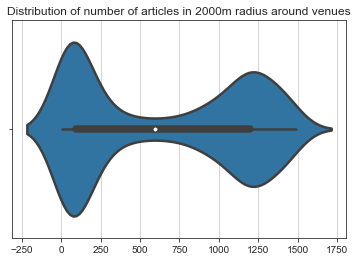

In [21]:
ax = sns.violinplot(list(structured_features["article_count"]), inner="box", linewidth=2.5)
plt.title(f"Distribution of number of articles in {MAX_DIST}m radius around venues")
plt.savefig(f"visualizations/article_distribution_{MAX_DIST}m.png", width=700, height=600, scale=1.5)

Save structured + text based features.

In [22]:
if ONLY_SUMMARY:
    structured_features.to_csv(PATH + f"structured_bert_{str(MAX_DIST)}_{WEIGHT_FUNC}.csv", index=False)
else:
    structured_features.to_csv(PATH + f"structured_bert_{str(MAX_DIST)}_{WEIGHT_FUNC}_FULL.csv", index=False)

### Create Embeddings for out of sample data for RFECV

In [23]:
df_structured = pd.read_csv(PATH + "structured_preprocessed_out_borough.csv")
df_structured.rename(columns={"lat":"latitude", "long":"longitude"}, inplace=True)
print(df_structured.shape)
df_structured.head()

(241, 7)


,venue_id,latitude,longitude,borough,category,org_category,total_visits
0,4b088119f964a520420d23e3,40.891799,-74.211735,NaN,Bar,Dive Bar,1
1,4b3e11e8f964a5201d9825e3,40.876140,-74.139872,NaN,Bar,Dive Bar,3
2,4b8c7598f964a520dbd132e3,40.871631,-74.087548,NaN,Bar,Dive Bar,2
3,4ba24e91f964a520b8eb37e3,40.811090,-74.122510,NaN,Bar,Dive Bar,9
4,4bca54b7cc8cd13a108ebdcf,40.662233,-74.264004,NaN,Bar,Dive Bar,2


In [24]:
df.reset_index(drop=True, inplace=True)  # make sure index is from 0 to n-1
structured_features = multiprocessor_wiki.process_text_features(df_structured, df, embedding_df.to_numpy(),
                                                                emb_col_names, MAX_DIST, CPU_CORES,
                                                                WEIGHTING, MEAN, WEIGHT_FUNC, K_CLOSEST)

print(structured_features.shape)
structured_features.head(10)

  0%|          | 0/100 [00:00<?, ?it/s]

(241, 3080)


,venue_id,latitude,longitude,borough,category,org_category,total_visits,embedding_0,embedding_1,embedding_2,...,embedding_3063,embedding_3064,embedding_3065,embedding_3066,embedding_3067,embedding_3068,embedding_3069,embedding_3070,embedding_3071,article_count
0,4b088119f964a520420d23e3,40.891799,-74.211735,NaN,Bar,Dive Bar,1,-0.019716,-0.026598,-0.023909,...,-0.015082,0.010508,-0.033798,0.005585,-0.004191,-0.007512,0.015505,0.007878,0.021956,12
1,4b3e11e8f964a5201d9825e3,40.87614,-74.139872,NaN,Bar,Dive Bar,3,-0.016037,-0.020826,-0.01951,...,-0.007928,0.004765,-0.012032,0.00934,-0.001287,-0.008945,0.01007,0.011002,0.013282,19
2,4b8c7598f964a520dbd132e3,40.871631,-74.087548,NaN,Bar,Dive Bar,2,-0.134171,-0.168981,-0.159048,...,-0.080352,0.089095,-0.215762,0.055131,-0.034219,-0.054769,0.121109,0.086303,0.182372,16
3,4ba24e91f964a520b8eb37e3,40.81109,-74.12251,NaN,Bar,Dive Bar,9,-0.10393,-0.15263,-0.148584,...,-0.085313,0.062011,-0.153963,0.048709,-0.011138,-0.04072,0.127239,0.059316,0.102241,23
4,4bca54b7cc8cd13a108ebdcf,40.662233,-74.264004,NaN,Bar,Dive Bar,2,-0.181676,-0.242084,-0.215564,...,-0.122232,0.111944,-0.282089,0.081326,-0.024224,-0.077719,0.201603,0.12487,0.168056,10
5,4bd0dd5c9854d13aa4a4f84d,40.882928,-74.107832,NaN,Bar,Dive Bar,3,-0.157725,-0.203347,-0.164397,...,-0.099383,0.09539,-0.209726,0.061988,-0.018017,-0.059134,0.160857,0.107567,0.13943,12
6,4c538e72fd2ea59341d49e28,40.85801,-74.1477,NaN,Bar,Dive Bar,25,-0.029068,-0.031303,-0.030037,...,-0.01554,0.011173,-0.029697,0.008827,-0.002111,-0.01422,0.016117,0.016494,0.025411,24
7,4c53b0df479fc9280fb9e391,40.626042,-74.259126,NaN,Bar,Dive Bar,12,-0.124913,-0.181569,-0.136162,...,-0.104996,0.056544,-0.176523,0.045715,0.005055,-0.027617,0.121856,0.084842,0.086077,8
8,4c55f8bc973fc9289e3137c8,40.876277,-74.123815,NaN,Bar,Dive Bar,11,-0.066437,-0.072816,-0.086849,...,-0.027981,0.016884,-0.057903,0.035332,-0.004745,-0.029434,0.058656,0.023123,0.053607,23
9,4c75c36ab474a1cd8c5fbabf,40.644918,-74.223657,NaN,Bar,Dive Bar,1,-0.027942,-0.04312,-0.03499,...,-0.015707,0.013569,-0.02385,0.016469,-0.005103,-0.00789,0.026855,0.02769,0.026609,17


In [25]:
no_articles = structured_features[structured_features.loc[:,"embedding_0":"article_count"].isna().any(axis=1)].shape[0]
print(f"Number of venues without a Wikipedia article nearby for radius {MAX_DIST}m: {no_articles}")

Number of venues without a Wikipedia article nearby for radius 2000m: 0


In [26]:
if ONLY_SUMMARY:
    structured_features.to_csv(PATH + f"structured_bert_out_borough_{str(MAX_DIST)}_{WEIGHT_FUNC}.csv", index=False)
else:
    structured_features.to_csv(PATH + f"structured_bert_out_borough_{str(MAX_DIST)}_{WEIGHT_FUNC}_FULL.csv", index=False)